# Developing a neural network from scratch

by Ali Fenwick

## Introduction

In this notebook, I will develop a neural net from scratch to illustrate the operations of the model (such as forward pass) and explain how neural networks optimize their prediction accuracy through a concept called backpropagation (Rumelhart et al., 1986a). This notebook is part of an assignment which explains the mathematics behind forward pass and backpropagation and aims to reflect how some of the equations are translated into code to allow the model to run effectively. 

## Dataset

A dataset has been provided by the examiner for use in this assignment to test the performance of the neural net. The dataset contains 1000 rows and 4 columns. 3 columns x variables which forms the input data for the model and 1 column which is the output variables Y which I aim to predict with the neural net. The Y variable consists of 0s and 1s, which means that the I will address a binary classification problem. Besides testing the dataset with the coded neural net, I will also us a logistic regression algorithm from sklearn to compare the results between both approaches.

## Forward Pass and Backpropagation.

In machine learning, forward propagation (or forward pass) refers to the calculation and storage of intermediate variables (including outputs) for a neural network going from the input layer to the output layer. Backpropagation, on the other hand, computes the gradient of the loss function with respect to the weights of the network for a single input–output example. This is an important step in neural networks, as this is the way the algorithm learns to correct the weights and biases for its model. Backpropagation evaluates the expression for the derivative of the cost function (following the chain rule) as a product of derivatives between each layer from right to left with the gradient of the weights between each layer being a simple modification of the partial products. 

# Coding Section

## The development of a neural network focusing on forward and backward propagation.

Let's start with loading the necessry libraries for the model development. 

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

Here I will load the dataset and explore the data briefly

In [ ]:
data = pd.read_csv("/content/assignment1_SeqNNs.csv")

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      1000 non-null   float64
 1   x2      1000 non-null   float64
 2   x3      1000 non-null   float64
 3   y       1000 non-null   float64
dtypes: float64(4)
memory usage: 31.4 KB


In [ ]:
data.describe()

,x1,x2,x3,y
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.013503,1.019268,0.533061,0.466000
std,1.032161,0.999535,1.019132,0.499092
min,-2.973315,-2.209955,-2.519478,0.000000
25%,-0.674494,0.327711,-0.162202,0.000000
50%,0.029750,1.012551,0.488647,0.000000
75%,0.669901,1.688176,1.193795,1.000000
max,3.695300,3.929661,4.357940,1.000000


# Developing a class for the neural net

Classes provide a means of bundling data and functionality together. Creating a new class creates a new type of object, allowing new instances of that type to be made. Each class instance can have attributes attached to it for maintaining its state. Class instances can also have methods (defined by its class) for modifying its state.

In this class, I will define the parameters such has the amount of hidden layers, regularization, training examples, learning rate, and batch side. After which, the class will reflect the one-hot encoding to define the Y output, sigmoid activation necessary to compute the output, the forward pass, the cost function, back propagation, and the gradient descent. The class also reflects the mathematical equations required for these operations.

In [ ]:
class NeuralNetMLP(object):
    
    """ Defining a class for deep learning model for a binanry classification 
    problem. Initializing the class with the following parameters: number of 
    hidden layers, epochs, and batch size.
    """

    def __init__(self, n_hidden=1, epochs=150, eta=0.001, seed=None, shuffle=True, 
                  minibatch_size=1):
        
        self.n_hidden = n_hidden
        self.epochs = epochs
        self.eta = eta
        self.random = np.random.RandomState(seed)
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size
            
    # defining function for the sigmoid equation - (σ): g(z) = 1 / (1 + e^{-z}). 

    def _sigmoid(self, z):
            return 1. / (1. + np.exp(-z))

        # defining a function for the forward pass

    def _forward(self, X):

            # Forward Pass
            # Stepwise approach starting with the net input (z) of the hidden layer. 
            # Next set the activation (a_h) of the hidden layer using the signoid function
            # (alternatively tanh can be used here like in the written assignment). 
            # Next step is the net input of the output layer (z_out) and finally the activation
            # of the output layer (a_out) using the signmoid function

        z_h = np.dot(X, self.w_h) + self.b_h
        a_h = self._sigmoid(z_h)
        z_out = np.dot(a_h, self.w_out) + self.b_out
        a_out = self._sigmoid(z_out)
        return z_h, a_h, z_out, a_out

            #Loss Function
            #After the forward pass we define the loss function Mean Square Error (MSE).
            #The left and right part of the loss function are calculated seperately.

    def _cost_function(self, y_real, output):
            
        left = -y_real * (np.log(output))
        right = (1. - y_real) * np.log(1. - output)
        cost = np.sum(left - right)
        return cost

    def predict(self, X):
        z_h, a_h, z_out, a_out = self._forward(X)
        y_pred = np.argmax(z_out, axis=1)
        return y_pred

    def fit(self, X_train, y_train, X_valid, y_valid):
            
        #Using the training data to update the weights
        n_output = np.unique(y_train).shape[0]  
        n_features = X_train.shape[1]

        # weights for input -> hidden
        self.b_h = np.zeros(self.n_hidden)
        self.w_h = self.random.normal(loc=0.0, scale=0.1,
                                      size=(n_features, self.n_hidden))

        # weights for hidden -> output
        self.b_out = np.zeros(n_output)
        self.w_out = self.random.normal(loc=0.0, scale=0.1,
                                        size=(self.n_hidden, n_output))

        epoch_strlen = len(str(self.epochs))  # for progress formatting
        self.eval_ = {'cost': [], 'train_acc': [], 'valid_acc': []}

        y_train_real = n_output

        # iterate over training epochs
        for i in range(self.epochs):

            # iterate over minibatches
            indices = np.arange(X_train.shape[0])

            if self.shuffle:
                self.random.shuffle(indices)

            for start in range(0, indices.shape[0] - self.minibatch_size +
                                    1, self.minibatch_size):
                batch = indices[start:start + self.minibatch_size]

                # forward propagation
                z_h, a_h, z_out, a_out = self._forward(X_train[batch])

                """Backpropagation algorithm adjusting the weights (delta) to find
                the correct measurements for the model. This is done by calculating 
                the partial derivative of the loss function over the weights using
                the chain rule."""

                # Calculating delta_h combining the delta out error (left-side of the equation 
                #of expression #4) together with the activation of the derivative 
                # (right-hand side of expression #4 on page 412). First we calculate with delta
                #output error (a_out is calculated Y) then we calculate the derivative of the
                #activation function. 
                
                delta_out = a_out - y_train_real #Step 1
                sigmoid_der_h = a_h * (1. - a_h) #Step 2
                delta_h = (np.dot(delta_out, self.w_out.T) *
                            sigmoid_der_h) #Step 3
                
                #Note: sigmoid derivative code represents the compact form of the 
                #derivative of the activation function from Luis' ppt 02
              

                #Computing Gradient Descent

                # Computing the loss gradient for the output layer in expression #1
                # of the book (page 412)
                grad_w_out = np.dot(a_h.T, delta_out)
                grad_b_out = np.sum(delta_out, axis=0)

                # Computing the loss gradient for the hidden layer in expression #5 
                # of the book (page 412)
                grad_w_h = np.dot(X_train[batch].T, delta_h)
                grad_b_h = np.sum(delta_h, axis=0)

                # Updating weights for both the hidden layer and the outer later. First,
                #let's calculate the hidden layer (see assignment 1 equations)
                delta_w_h = grad_w_h + self.w_h
                delta_b_h = grad_b_h 
                self.w_h -= self.eta * delta_w_h # updating weights of hidden layer
                self.b_h -= self.eta * delta_b_h # updating bias of hidden layer

                delta_w_out = grad_w_out + self.w_out 
                delta_b_out = grad_b_out  
                self.w_out -= self.eta * delta_w_out # updating weights of the output layer
                self.b_out -= self.eta * delta_b_out # updating nias of the output layer


             # Model Evaluation

            # During training evaluate each epoch
            z_h, a_h, z_out, a_out = self._forward(X_train)
            
            cost = self._cost_function(y_real=y_train_real,
                                      output=a_out)

            train_y_pred = self.predict(X_train)
            valid_y_pred = self.predict(X_valid)

            train_accuracy = ((np.sum(y_train == train_y_pred)).astype(np.float) /
                          X_train.shape[0])
            valid_accuracy = ((np.sum(y_valid == valid_y_pred)).astype(np.float) /
                          X_valid.shape[0])

            import sys
            sys.stderr.write('\r%0*d/%d | Cost: %.2f '
                              '| Train/Valid Acc.: %.2f%%/%.2f%% ' %
                              (epoch_strlen, i+1, self.epochs, cost,
                              train_accuracy*100, valid_accuracy*100))
            sys.stderr.flush()

            self.eval_['cost'].append(cost)
            self.eval_['train_acc'].append(train_accuracy)
            self.eval_['valid_acc'].append(valid_accuracy)

        return self

In this section, I will divide the dataset into a training and test set. 80% of the data will be used to train the model and 20% of the data will be used to test the model once trained. The model will run 200 training examples to evaluate the model performance.

In [ ]:
n_epochs = 200

# for the linear classifier
train_x = data.values[:800,:-1]
train_y = data.values[:800,-1]

test_x = data.values[800:,:-1]
test_y = data.values[800:,-1]

Here the model is fitted and runs on both the test and validation set. 

In [ ]:
nn = NeuralNetMLP(n_hidden=1,  
                  epochs=n_epochs, 
                  eta=0.001,
                  minibatch_size=100, 
                  shuffle=True,
                  seed=1)

nn.fit(train_x, train_y, test_x, test_y)
      

200/200 | Cost: 278.53 | Train/Valid Acc.: 94.88%/95.00% 

Model performance is 94.88% for the training set and 95.00% for the validtion set which shows good model fit.

# Testing the dataset with sklearn's LogisticRegression() algorithm and comparimg the results with the neural net.

Load necessary librabries

In [ ]:
from sklearn.linear_model import LogisticRegression

Create training and test sets

In [ ]:
from sklearn.model_selection import train_test_split
X_train, y_train, X_test, y_test = train_test_split(train_x, train_y, test_size=0.20)

Loading the logistical regression algorithm fitting it with the data

In [ ]:
logreg = LogisticRegression()
logreg.fit(train_x, train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Training accuracy is 94.4%

In [ ]:
logreg.score(train_x, train_y)

0.94375

Validation set accuracy is 95%

In [ ]:
# Use score method to get accuracy of model
score = logreg.score(test_x, test_y)
print(score)

0.95


In [ ]:
predictions = logreg.predict(test_x)
print(predictions)

[0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1.
 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0.
 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1.
 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0.
 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1.
 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0.
 1. 0. 1. 1. 1. 1. 0. 0.]


Here I also conducted a confusion matrix which shows great results.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

cm = metrics.confusion_matrix(test_y, predictions)
print(cm)

[[100   7]
 [  3  90]]


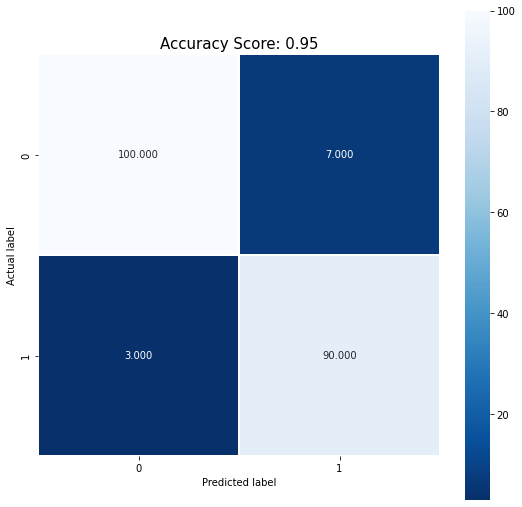

In [ ]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

# Summary of Neural Net Design and Testing

The design of the neural net in python, without using existing librabries like Keras and Tensorflow, was an interesting exercise. It helped to understand the math underlying forward pass, backpropagation, and gradient descent and how to code these various algoritms. Having a solid understanding of how the mechanics work of neural nets is crucial for model design and improvement.

In this notebook, the performance of a neural net was compared with that of a logistical regression algorithm from sklearn using a provided dataset. The model addressed a binary classification problem predicting either 0 or 1 in the output variable Y using three input columns X. Model accuracy and the loss function were measures of performance. Both models performed equally well showing 94.4% - 94.8% training accuracy and 95.0% validation accuracy. 

# Limitations

* This assignment was particularly challenging due to some initial lack in understanding of the derivative calculations. Nevertheless, a very learningful exercise to better understand how things work under the hood compared to using Keras and Tensorflow to design neural networks. This assignment has increased my appreciation for better understanding the math underlying the development of neural networks and the translation of these equations into code. 

* The neural net was representated in the current format. However, there are many other ways you can code a neural network. There is no perfect script. Parts of the neural net were inspired by creations of other developers and practice code from the book Python Machine Learning (Raschka, S. & Mirjalili, V., 2017). I will familiarize myself more in building neural nets from scratch in the coming months to be able to build such models more independently.

* Hyperparameter tuning could have been applied more to find a better loss and accuracy curve. Future trials could improve the overall model performance by further tuning the parameters even though in this case the dataset was not that big. 



# References

Amari, S. (1993). Backpropagation and stochastic gradient descent method. Neurocomputing, 5, 185-196.

Brilliant. Backpropagation. Retrieved from https://brilliant.org/wiki/backpropagation/ 

P. J. Werbos, "Backpropagation through time: what it does and how to do it," in Proceedings of the IEEE, vol. 78, no. 10, pp. 1550-1560

Raschka, S., & Mirjalili, V. (2017). Machine learning mit Python und Scikit-Learn und TensorFlow: Das Praxis-Handbuch für Data Science, Predictive Analytics und Deep Learning. MITP Verlags GmbH & Company KG.

Rumelhart, David E.; Hinton, Geoffrey E.; Williams, Ronald J. (1986b). "8. Learning Internal Representations by Error Propagation". In Rumelhart, David E.; McClelland, James L. (eds.). Parallel Distributed Processing : Explorations in the Microstructure of Cognition. Volume 1 : Foundations. Cambridge: MIT Press. ISBN 0-262-18120-7.

Wikipedia. Backpropagation. Retrieved from https://en.wikipedia.org/wiki/Backpropagation